ResNet 50

Unexpected class label 'ref.prev' found in entry with key 428
Unexpected class label 'combination of oa, ra' found in entry with key 495
Unexpected class label 'ref.prev' found in entry with key 838
Unexpected class label 'ref.prev' found in entry with key 1772
Unexpected class label 'ref.prev' found in entry with key 1867
Unexpected class label 'ref.prev' found in entry with key 1871
Unexpected class label 'ref.prev' found in entry with key 1903
Unexpected class label 'ref.prev' found in entry with key 1919
Unexpected class label 'ref.prev' found in entry with key 1941
Unexpected class label 'ref.prev' found in entry with key 1942
Unexpected class label 'ref.prev' found in entry with key 1945
Unexpected class label 'ref.prev' found in entry with key 1949
Unexpected class label 'ref.prev' found in entry with key 2013
Unexpected class label 'ref.prev' found in entry with key 2016
Unexpected class label 'ref.prev' found in entry with key 2017
Unexpected class label 'ref.prev' found in en

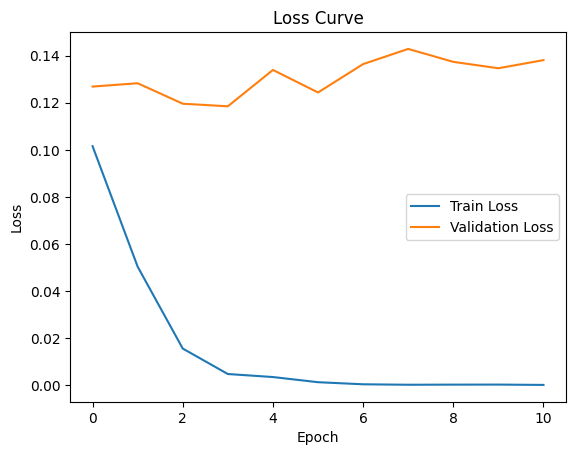

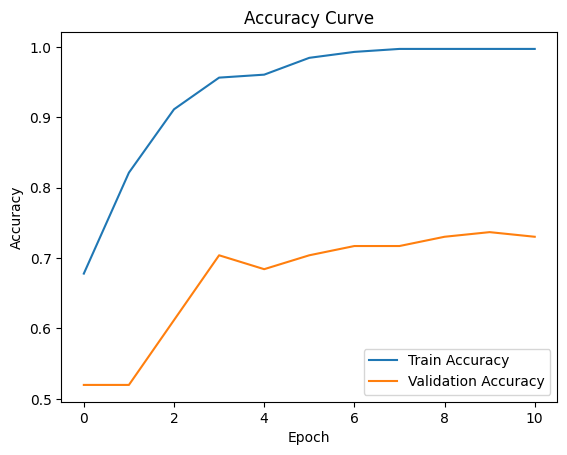

Test Accuracy: 0.6340, F1 Score: 0.6410, AUC: 0.6481


In [1]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from PIL import Image
import os

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Normalize class labels
class_counts = {'oa': 0, 'gout': 0, 'normal': 0, 'uncertain': 0, 'ra': 0}
for key, entry in data.items():
    if isinstance(entry, dict):
        class_label = entry.get('class', '').lower()
        if class_label in class_counts:
            class_counts[class_label] += 1
        else:
            print(f"Unexpected class label '{class_label}' found in entry with key {key}")

print("Class Distribution:", class_counts)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------------
# 2. Dataset and DataLoader
# -------------------------------
# Apply horizontal flipping for data augmentation during training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

# No augmentation for validation and test
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class FootDataset(Dataset):
    def __init__(self, data, classes, transform):
        self.data = []
        self.labels = []
        self.transform = transform
        for entry in data:
            if entry['class'].lower() in classes:
                label = 1 if entry['class'].lower() == classes[0] else 0
                file_path = entry['file_path']
                if os.path.exists(file_path):
                    self.data.append(file_path)
                    self.labels.append(label)
                else:
                    print(f"File not found: {file_path}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label

# Prepare binary data
def prepare_binary_data(data, target_class, normal_class='normal'):
    target_entries = [entry for entry in data.values() if entry['class'].lower() == target_class]
    normal_entries = random.sample([entry for entry in data.values() if entry['class'].lower() == normal_class], len(target_entries))
    combined_data = target_entries + normal_entries
    random.shuffle(combined_data)
    return combined_data

selected_classes = ('oa', 'normal')
binary_data = prepare_binary_data(data, selected_classes[0])

# Dataset and Split
dataset = FootDataset(binary_data, selected_classes, transform=train_transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply appropriate transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Balanced Sampling
class_sample_count = [len([label for label in train_dataset.dataset.labels if label == t]) for t in [0, 1]]
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
samples_weights = [weights[label] for label in [train_dataset.dataset.labels[i] for i in train_dataset.indices]]
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -------------------------------
# 3. Model Definition
# -------------------------------
# Fine-Tune ResNet50
cnn_model = resnet50(weights=ResNet50_Weights.DEFAULT)
for param in cnn_model.parameters():
    param.requires_grad = False
for name, param in cnn_model.named_parameters():
    if "layer2" in name or "layer3" in name or "layer4" in name:
        param.requires_grad = True

cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 1)
cnn_model = cnn_model.to(device)

# -------------------------------
# 4. Loss Functions
# -------------------------------
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        BCE_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

criterion = FocalLoss(alpha=0.75, gamma=2)

# -------------------------------
# 5. Training Setup
# -------------------------------
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=7, verbose=True)

# -------------------------------
# 6. Training Loop
# -------------------------------
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
train_f1_scores, val_f1_scores, train_aucs, val_aucs = [], [], [], []

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    epoch_f1 = f1_score(all_labels, all_preds)
    epoch_auc = roc_auc_score(all_labels, all_preds)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    train_f1_scores.append(epoch_f1)
    train_aucs.append(epoch_auc)

    # Validation
    cnn_model.eval()
    val_running_loss = 0.0
    val_preds, val_labels_all = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = cnn_model(images).squeeze()
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_preds.extend(preds.cpu().numpy())
            val_labels_all.extend(labels.cpu().numpy())

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = np.mean(np.array(val_preds) == np.array(val_labels_all))
    val_epoch_f1 = f1_score(val_labels_all, val_preds)
    val_epoch_auc = roc_auc_score(val_labels_all, val_preds)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    val_f1_scores.append(val_epoch_f1)
    val_aucs.append(val_epoch_auc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}, AUC: {epoch_auc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}, F1: {val_epoch_f1:.4f}, AUC: {val_epoch_auc:.4f}")

    # Early stopping
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# -------------------------------
# 7. Plotting Results
# -------------------------------
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# -------------------------------
# 8. Final Evaluation on Test Set
# -------------------------------
cnn_model.eval()
test_preds, test_labels_all = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = cnn_model(images).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.extend(preds.cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())

test_accuracy = np.mean(np.array(test_preds) == np.array(test_labels_all))
test_f1 = f1_score(test_labels_all, test_preds)
test_auc = roc_auc_score(test_labels_all, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}, AUC: {test_auc:.4f}")


CNN + Transformer

Unexpected class label 'ref.prev' found in entry with key 1772
Unexpected class label 'ref.prev' found in entry with key 1867
Unexpected class label 'ref.prev' found in entry with key 1871
Unexpected class label 'ref.prev' found in entry with key 1903
Unexpected class label 'ref.prev' found in entry with key 1941
Unexpected class label 'ref.prev' found in entry with key 1942
Unexpected class label 'ref.prev' found in entry with key 1945
Unexpected class label 'ref.prev' found in entry with key 1949
Unexpected class label 'ref.prev' found in entry with key 2013
Unexpected class label 'ref.prev' found in entry with key 2016
Unexpected class label 'ref.prev' found in entry with key 2017
Unexpected class label 'ref.prev' found in entry with key 2020
Unexpected class label 'ref.prev' found in entry with key 2058
Unexpected class label 'ref.prev' found in entry with key 2062
Unexpected class label 'ref.prev' found in entry with key 2124
Unexpected class label 'ref.prev' found in entry with k

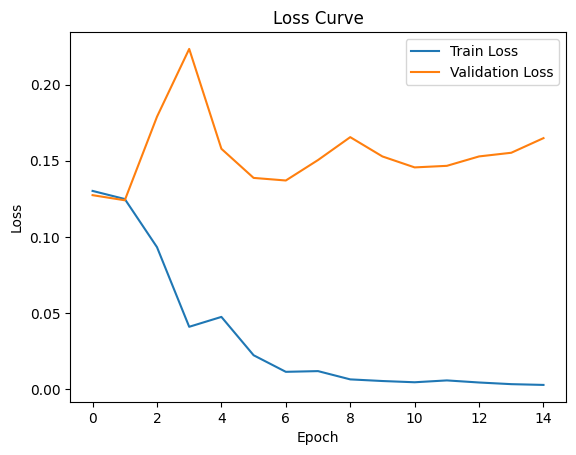

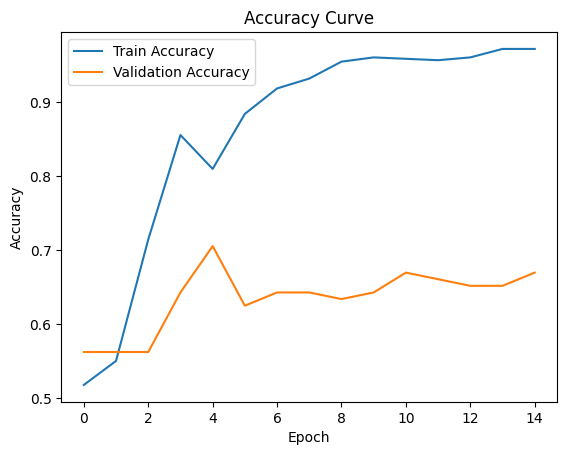

Test Accuracy: 0.6726, F1 Score: 0.6542, AUC: 0.7378


In [2]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from PIL import Image
import os

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------
with open('updated_merge_json_150x250.pkl', 'rb') as f:
    data = pickle.load(f)

# Normalize class labels
class_counts = {'oa': 0, 'gout': 0, 'normal': 0, 'uncertain': 0, 'ra': 0}
for key, entry in data.items():
    if isinstance(entry, dict):
        class_label = entry.get('class', '').lower()
        if class_label in class_counts:
            class_counts[class_label] += 1
        else:
            print(f"Unexpected class label '{class_label}' found in entry with key {key}")

print("Class Distribution:", class_counts)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------------
# 2. Dataset and DataLoader
# -------------------------------
# Transformations for raw images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Modified Dataset class to load raw images
class FootDataset(Dataset):
    def __init__(self, data, classes, transform):
        self.data = []
        self.labels = []
        self.transform = transform
        for entry in data:
            if entry['class'].lower() in classes:
                label = 1 if entry['class'].lower() == classes[0] else 0
                file_path = entry['file_path']
                if os.path.exists(file_path):
                    self.data.append(file_path)
                    self.labels.append(label)
                else:
                    print(f"File not found: {file_path}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label

# Prepare binary data
def prepare_binary_data(data, target_class, normal_class='normal'):
    target_entries = [entry for entry in data.values() if entry['class'].lower() == target_class]
    normal_entries = random.sample([entry for entry in data.values() if entry['class'].lower() == normal_class], len(target_entries))
    combined_data = target_entries + normal_entries
    random.shuffle(combined_data)
    return combined_data

selected_classes = ('oa', 'normal')
binary_data = prepare_binary_data(data, selected_classes[0])

# Dataset and Split
dataset = FootDataset(binary_data, selected_classes, transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Balanced Sampling
class_sample_count = [len([label for label in train_dataset.dataset.labels if label == t]) for t in [0, 1]]
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
samples_weights = [weights[label] for label in [train_dataset.dataset.labels[i] for i in train_dataset.indices]]
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -------------------------------
# 3. Model Definition
# -------------------------------
# CNN + Transformer Model
class CNN_Transformer_Model(nn.Module):
    def __init__(self, cnn_output_dim=2048, transformer_dim=512, num_heads=8, num_transformer_layers=4):
        super(CNN_Transformer_Model, self).__init__()

        # Pretrained ResNet50 for feature extraction
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-2])  # (B, 2048, 7, 7)

        # Projection for transformer
        self.conv_projection = nn.Conv2d(cnn_output_dim, transformer_dim, kernel_size=1)

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, 7*7, transformer_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(cnn_output_dim + transformer_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # CNN Features
        cnn_features = self.cnn_backbone(x)  # (B, 2048, 7, 7)
        batch_size, c, h, w = cnn_features.shape

        # Projection for Transformer
        projected_features = self.conv_projection(cnn_features)  # (B, transformer_dim, 7, 7)
        projected_features = projected_features.flatten(2).permute(0, 2, 1)  # (B, 49, transformer_dim)
        projected_features += self.positional_encoding

        # Transformer
        global_features = self.transformer_encoder(projected_features)
        global_features_pooled = global_features.mean(dim=1)  # (B, transformer_dim)

        # Pool CNN Features
        local_features_pooled = nn.AdaptiveAvgPool2d((1, 1))(cnn_features).view(batch_size, -1)

        # Combine and Classify
        combined_features = torch.cat((local_features_pooled, global_features_pooled), dim=1)
        output = self.classifier(combined_features)
        return output

# -------------------------------
# 4. Loss Functions
# -------------------------------
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCELoss()

    def forward(self, inputs, targets):
        BCE_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

criterion = FocalLoss(alpha=0.75, gamma=2)

# -------------------------------
# 5. Training Setup
# -------------------------------
# Initialize Model, Optimizer, and Scheduler
model = CNN_Transformer_Model().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# -------------------------------
# 6. Training Loop
# -------------------------------
num_epochs = 15
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
train_f1_scores, val_f1_scores, train_aucs, val_aucs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    all_labels, all_preds, all_probs = [], [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Metrics
        preds = (outputs > 0.5).float()
        running_loss += loss.item() * images.size(0)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(outputs.detach().cpu().numpy())

    scheduler.step()
    epoch_loss = running_loss / total_preds
    epoch_acc = correct_preds / total_preds
    epoch_f1 = f1_score(all_labels, all_preds)
    epoch_auc = roc_auc_score(all_labels, all_probs)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    train_f1_scores.append(epoch_f1)
    train_aucs.append(epoch_auc)

    # Validation
    model.eval()
    val_running_loss, val_correct_preds, val_total_preds = 0.0, 0, 0
    val_labels_list, val_preds_list, val_probs_list = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            val_loss = criterion(outputs, labels)

            preds = (outputs > 0.5).float()
            val_running_loss += val_loss.item() * images.size(0)
            val_correct_preds += (preds == labels).sum().item()
            val_total_preds += labels.size(0)

            val_labels_list.extend(labels.cpu().numpy())
            val_preds_list.extend(preds.cpu().numpy())
            val_probs_list.extend(outputs.detach().cpu().numpy())

    val_epoch_loss = val_running_loss / val_total_preds
    val_epoch_acc = val_correct_preds / val_total_preds
    val_epoch_f1 = f1_score(val_labels_list, val_preds_list)
    val_epoch_auc = roc_auc_score(val_labels_list, val_probs_list)

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    val_f1_scores.append(val_epoch_f1)
    val_aucs.append(val_epoch_auc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}, AUC: {epoch_auc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, F1: {val_epoch_f1:.4f}, AUC: {val_epoch_auc:.4f}")

# -------------------------------
# 7. Plotting Results
# -------------------------------
# Loss Curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Accuracy Curves
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# -------------------------------
# 8. Final Evaluation on Test Set
# -------------------------------
model.eval()
test_labels_list, test_preds_list, test_probs_list = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images).squeeze()
        preds = (outputs > 0.5).float()

        test_labels_list.extend(labels.cpu().numpy())
        test_preds_list.extend(preds.cpu().numpy())
        test_probs_list.extend(outputs.detach().cpu().numpy())

test_accuracy = (np.array(test_preds_list) == np.array(test_labels_list)).mean()
test_f1 = f1_score(test_labels_list, test_preds_list)
test_auc = roc_auc_score(test_labels_list, test_probs_list)

print(f"Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}, AUC: {test_auc:.4f}")


ResNet50 + Swin Transformer

Class Distribution: {'oa': 375, 'gout': 210, 'normal': 568, 'uncertain': 454, 'ra': 60}
Using device: cuda


/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.1248, Train Acc: 0.5962, F1: 0.4928, AUC: 0.6370, Val Loss: 0.1062, Val Acc: 0.6696, F1: 0.6542, AUC: 0.7784
Epoch [2/10], Train Loss: 0.1089, Train Acc: 0.6800, F1: 0.6693, AUC: 0.7233, Val Loss: 0.1009, Val Acc: 0.6964, F1: 0.7463, AUC: 0.7545
Epoch [3/10], Train Loss: 0.0931, Train Acc: 0.7429, F1: 0.7368, AUC: 0.7934, Val Loss: 0.1078, Val Acc: 0.6786, F1: 0.7353, AUC: 0.7350
Epoch [4/10], Train Loss: 0.0788, Train Acc: 0.7848, F1: 0.7601, AUC: 0.8245, Val Loss: 0.1787, Val Acc: 0.6071, F1: 0.6944, AUC: 0.7583
Epoch [5/10], Train Loss: 0.0643, Train Acc: 0.8133, F1: 0.8040, AUC: 0.8685, Val Loss: 0.1772, Val Acc: 0.5714, F1: 0.6712, AUC: 0.6632
Epoch [6/10], Train Loss: 0.0530, Train Acc: 0.8438, F1: 0.8411, AUC: 0.9068, Val Loss: 0.1594, Val Acc: 0.5893, F1: 0.6806, AUC: 0.6845
Epoch [7/10], Train Loss: 0.0322, Train Acc: 0.8933, F1: 0.8955, AUC: 0.9494, Val Loss: 0.1175, Val Acc: 0.6786, F1: 0.6667, AUC: 0.7542
Epoch [8/10], Train Loss: 0.0358, Train A

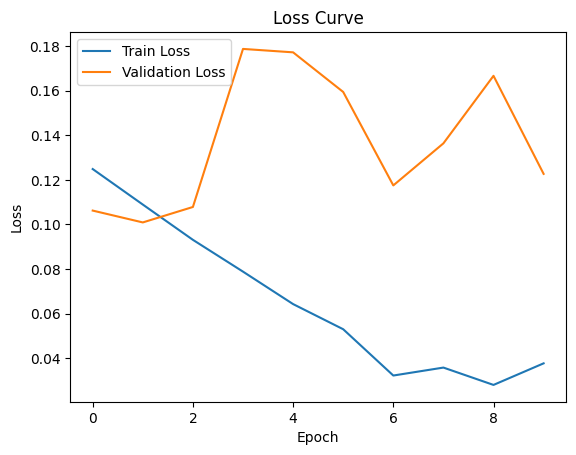

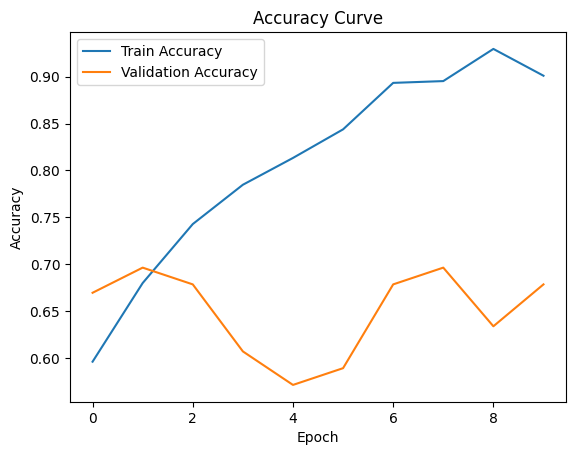

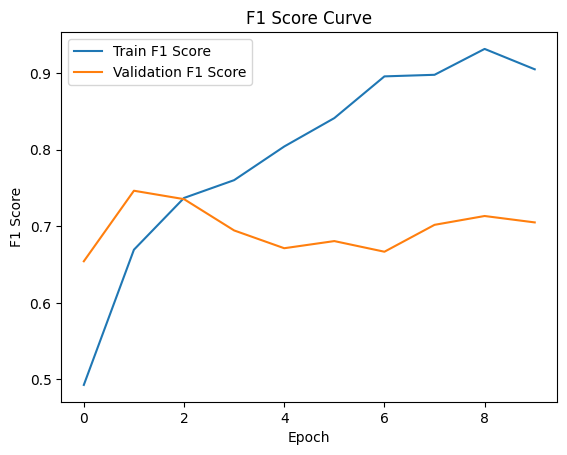

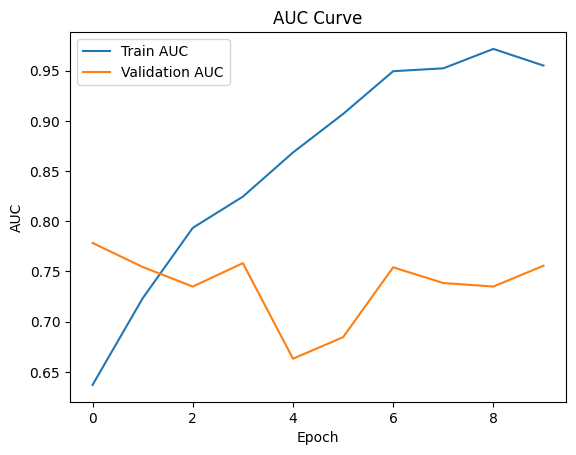

Test Accuracy: 0.6991, F1 Score: 0.7018, AUC: 0.7481


In [1]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms, models
from timm import create_model  # For Swin Transformer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from PIL import Image
import os

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------
with open('updated_merge_json_150x250.pkl', 'rb') as f:
    data = pickle.load(f)

# Normalize class labels
class_counts = {'oa': 0, 'gout': 0, 'normal': 0, 'uncertain': 0, 'ra': 0}
for key, entry in data.items():
    if isinstance(entry, dict):
        class_label = entry.get('class', '').lower()
        if class_label in class_counts:
            class_counts[class_label] += 1
        #else:
            #print(f"Unexpected class label '{class_label}' found in entry with key {key}")

print("Class Distribution:", class_counts)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------------
# 2. Dataset and DataLoader
# -------------------------------
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Modified Dataset to load raw images from file_path
class FootDataset(Dataset):
    def __init__(self, data, classes, transform):
        self.data = []
        self.labels = []
        self.transform = transform
        for entry in data:
            if entry['class'].lower() in classes:
                label = 1 if entry['class'].lower() == classes[0] else 0
                file_path = entry['file_path']
                if os.path.exists(file_path):
                    self.data.append(file_path)
                    self.labels.append(label)
                else:
                    print(f"File not found: {file_path}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label

# Prepare binary data
def prepare_binary_data(data, target_class, normal_class='normal'):
    target_entries = [entry for entry in data.values() if entry['class'].lower() == target_class]
    normal_entries = random.sample([entry for entry in data.values() if entry['class'].lower() == normal_class], len(target_entries))
    combined_data = target_entries + normal_entries
    random.shuffle(combined_data)
    return combined_data

selected_classes = ('oa', 'normal')
binary_data = prepare_binary_data(data, selected_classes[0])

# Dataset and Split
dataset = FootDataset(binary_data, selected_classes, transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Balanced Sampling
class_sample_count = [len([label for label in train_dataset.dataset.labels if label == t]) for t in [0, 1]]
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
samples_weights = [weights[label] for label in [train_dataset.dataset.labels[i] for i in train_dataset.indices]]
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# -------------------------------
# 3. Two-Branch Model Definitio16
# -------------------------------
class TwoBranchModel(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchModel, self).__init__()

        # Global Branch: Swin Transformer
        self.global_branch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.global_branch.head = nn.Identity()  # Remove original head
        self.global_feature_dim = self.global_branch.num_features

        # Local Branch: ResNet50
        resnet = models.resnet50(pretrained=pretrained)
        self.local_branch = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
        self.local_feature_dim = resnet.fc.in_features  # Usually 2048

        # Calculate combined features dynamically
        combined_features_dim = self.global_feature_dim + self.local_feature_dim

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(combined_features_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        # Global Branch - Swin Transformer
        global_features = self.global_branch.forward_features(x)  # Get feature maps
        #print(f"Raw Global Features Shape: {global_features.shape}")

        # Apply Mean Pooling over spatial dimensions
        if global_features.dim() == 4:
            # Assuming global_features shape: (B, C, H, W)
            global_features = global_features.mean(dim=[2, 3])  # Pool over H and W
        elif global_features.dim() == 3:
            # For shape: (B, N, C), pool over N
            global_features = global_features.mean(dim=1)

        #print(f"Processed Global Features Shape: {global_features.shape}")

        # Local Branch - ResNet50
        local_features = self.local_branch(x)  # Output from ResNet50
        local_features = local_features.view(local_features.size(0), -1)  # Flatten to (B, 2048)
        #print(f"Local Features Shape: {local_features.shape}")

        # Concatenate Global and Local Features
        combined_features = torch.cat((global_features, local_features), dim=1)  # Shape: (B, combined_dim)
        #print(f"Combined Features Shape: {combined_features.shape}")

        # Dynamically Adjust Classifier Input Layer if needed
        if combined_features.shape[1] != self.classifier[0].in_features:
            #print(f"Adjusting Linear Layer Input Dimension from {self.classifier[0].in_features} to {combined_features.shape[1]}")
            self.classifier[0] = nn.Linear(combined_features.shape[1], 512).to(x.device)

        # Classification
        output = self.classifier(combined_features)
        return output





# Initialize Model
model = TwoBranchModel(pretrained=True).to(device)

# -------------------------------
# 4. Loss Function
# -------------------------------
# Focal Loss for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCELoss()

    def forward(self, inputs, targets):
        BCE_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

criterion = FocalLoss(alpha=0.75, gamma=2)

# -------------------------------
# 5. Optimizer and Scheduler
# -------------------------------
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# -------------------------------
# 6. Training Loop
# -------------------------------
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
train_f1_scores, val_f1_scores, train_aucs, val_aucs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    all_labels, all_preds, all_probs = [], [], []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().to(device).unsqueeze(1)  # Ensure labels shape is (B, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Metrics
        preds = (outputs > 0.5).float()
        running_loss += loss.item() * images.size(0)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(outputs.detach().cpu().numpy())

    scheduler.step()
    epoch_loss = running_loss / total_preds
    epoch_acc = correct_preds / total_preds
    epoch_f1 = f1_score(all_labels, all_preds)
    epoch_auc = roc_auc_score(all_labels, all_probs)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    train_f1_scores.append(epoch_f1)
    train_aucs.append(epoch_auc)

    # Validation
    model.eval()
    val_running_loss, val_correct_preds, val_total_preds = 0.0, 0, 0
    val_labels_list, val_preds_list, val_probs_list = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device).unsqueeze(1)

            outputs = model(images)
            val_loss = criterion(outputs, labels)

            preds = (outputs > 0.5).float()
            val_running_loss += val_loss.item() * images.size(0)
            val_correct_preds += (preds == labels).sum().item()
            val_total_preds += labels.size(0)

            val_labels_list.extend(labels.cpu().numpy())
            val_preds_list.extend(preds.cpu().numpy())
            val_probs_list.extend(outputs.detach().cpu().numpy())

    val_epoch_loss = val_running_loss / val_total_preds
    val_epoch_acc = val_correct_preds / val_total_preds
    val_epoch_f1 = f1_score(val_labels_list, val_preds_list)
    val_epoch_auc = roc_auc_score(val_labels_list, val_probs_list)

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    val_f1_scores.append(val_epoch_f1)
    val_aucs.append(val_epoch_auc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}, AUC: {epoch_auc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, F1: {val_epoch_f1:.4f}, AUC: {val_epoch_auc:.4f}")

# -------------------------------
# 7. Plotting Results
# -------------------------------
# Loss Curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Accuracy Curves
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# F1 Score Curve
plt.figure()
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

# AUC Curve
plt.figure()
plt.plot(train_aucs, label='Train AUC')
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Curve')
plt.legend()
plt.show()

# -------------------------------
# 8. Final Evaluation on Test Set
# -------------------------------
model.eval()
test_labels_list, test_preds_list, test_probs_list = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().to(device).unsqueeze(1)

        outputs = model(images)
        preds = (outputs > 0.5).float()

        test_labels_list.extend(labels.cpu().numpy())
        test_preds_list.extend(preds.cpu().numpy())
        test_probs_list.extend(outputs.detach().cpu().numpy())

test_accuracy = (np.array(test_preds_list) == np.array(test_labels_list)).mean()
test_f1 = f1_score(test_labels_list, test_preds_list)
test_auc = roc_auc_score(test_labels_list, test_probs_list)

print(f"Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}, AUC: {test_auc:.4f}")


Class Distribution before balancing: {'oa': 508, 'gout': 242, 'normal': 693, 'uncertain': 549, 'ra': 90}
Using device: cuda
Balanced Data: OA: 508, NORMAL: 508
Total images after in-memory augmentation: 2032
Epoch [1/20], Train Loss: 0.6714, Train Accuracy: 0.5858
Validation Loss: 0.6207, Validation Accuracy: 0.6776
Epoch [2/20], Train Loss: 0.6496, Train Accuracy: 0.6350
Validation Loss: 0.6558, Validation Accuracy: 0.6349
Epoch [3/20], Train Loss: 0.6102, Train Accuracy: 0.6842
Validation Loss: 0.6260, Validation Accuracy: 0.6776
Epoch [4/20], Train Loss: 0.5771, Train Accuracy: 0.6983
Validation Loss: 0.6005, Validation Accuracy: 0.6809
Epoch [5/20], Train Loss: 0.5042, Train Accuracy: 0.7609
Validation Loss: 0.6411, Validation Accuracy: 0.6711
Epoch [6/20], Train Loss: 0.3802, Train Accuracy: 0.8488
Validation Loss: 0.8912, Validation Accuracy: 0.6151
Epoch [7/20], Train Loss: 0.2655, Train Accuracy: 0.9072
Validation Loss: 0.6637, Validation Accuracy: 0.6842
Epoch [8/20], Train Lo

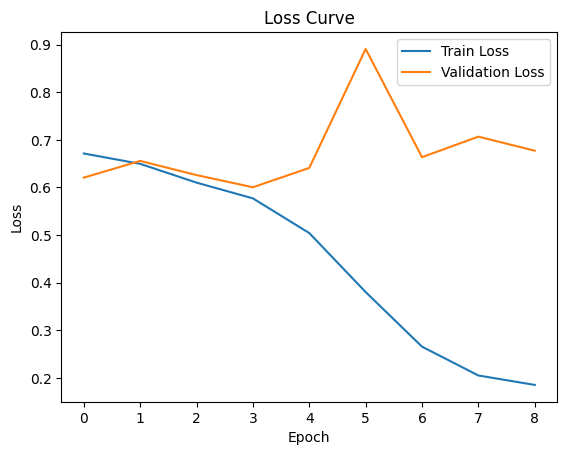

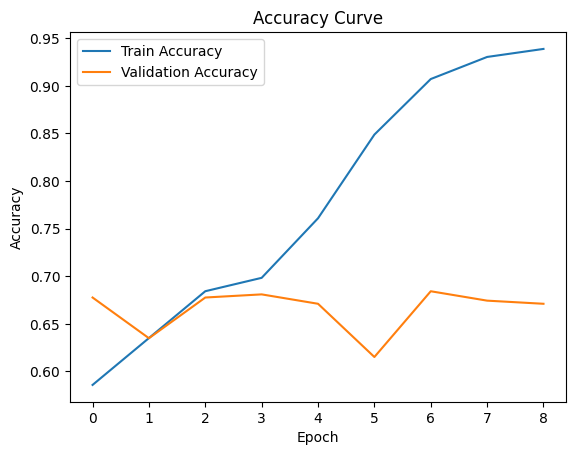

Test Accuracy: 0.7124, F1 Score: 0.7105, AUC: 0.7746


In [4]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model  # For Swin Transformer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from PIL import Image, ImageOps
import os

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Normalize class labels
class_counts = {'oa': 0, 'gout': 0, 'normal': 0, 'uncertain': 0, 'ra': 0}
for key, entry in data.items():
    if isinstance(entry, dict):
        class_label = entry.get('class', '').lower()
        if class_label in class_counts:
            class_counts[class_label] += 1

print("Class Distribution before balancing:", class_counts)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------------
# 2. Dataset and DataLoader with Augmentation
# -------------------------------
# Image transformations
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Modified Dataset to load raw images with in-memory augmentation
class FootDataset(Dataset):
    def __init__(self, data, classes, transform, augment=False):
        self.data = []
        self.labels = []
        self.transform = transform
        self.augment = augment
        for entry in data:
            if entry['class'].lower() in classes:
                label = 1 if entry['class'].lower() == classes[0] else 0
                file_path = entry['file_path']
                if os.path.exists(file_path):
                    self.data.append(file_path)
                    self.labels.append(label)
                else:
                    print(f"File not found: {file_path}")

        self.original_len = len(self.data)

    def __len__(self):
        # Double the dataset size if augmenting
        return len(self.data) * 2 if self.augment else len(self.data)

    def __getitem__(self, idx):
        # Apply augmentation to half the dataset
        augment_image = self.augment and idx >= self.original_len
        actual_idx = idx % self.original_len

        image_path = self.data[actual_idx]
        label = self.labels[actual_idx]

        image = Image.open(image_path).convert('RGB')
        if augment_image:
            image = ImageOps.mirror(image)

        image = self.transform(image)
        return image, label

# Prepare balanced binary data with augmentation
def prepare_balanced_data(data, target_class, normal_class='normal'):
    target_entries = [entry for entry in data.values() if entry['class'].lower() == target_class]
    normal_entries = [entry for entry in data.values() if entry['class'].lower() == normal_class]
    min_count = min(len(target_entries), len(normal_entries))

    target_entries = random.sample(target_entries, min_count)
    normal_entries = random.sample(normal_entries, min_count)

    combined_data = target_entries + normal_entries
    random.shuffle(combined_data)

    print(f"Balanced Data: {target_class.upper()}: {len(target_entries)}, {normal_class.upper()}: {len(normal_entries)}")
    return combined_data

selected_classes = ('oa', 'normal')
balanced_data = prepare_balanced_data(data, selected_classes[0])

# Dataset with augmentation (in-memory)
dataset = FootDataset(balanced_data, selected_classes, base_transform, augment=True)
print(f"Total images after in-memory augmentation: {len(dataset)}")

# -------------------------------
# 3. Split Data
# -------------------------------
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# -------------------------------
# 4. Early Stopping Implementation
# -------------------------------
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize Early Stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# -------------------------------
# 5. Model Definition (Swin Transformer + ResNet with Dynamic Features)
# -------------------------------
class TwoBranchModel(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchModel, self).__init__()

        # Global Branch: Swin Transformer
        self.global_branch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.global_branch.head = nn.Identity()

        # Local Branch: ResNet50
        resnet = models.resnet50(pretrained=pretrained)
        self.local_branch = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer

        # Placeholder for feature dimensions (to be set dynamically)
        self.combined_feature_dim = None

        # Classifier (initialized later when feature dimensions are known)
        self.classifier = None

    def forward(self, x):
        # Global Branch - Swin Transformer
        global_features = self.global_branch.forward_features(x)
        if global_features.dim() == 4:
            global_features = global_features.mean(dim=[2, 3])
        elif global_features.dim() == 3:
            global_features = global_features.mean(dim=1)

        # Local Branch - ResNet50
        local_features = self.local_branch(x)
        local_features = local_features.view(local_features.size(0), -1)

        # Concatenate Global and Local Features
        combined_features = torch.cat((global_features, local_features), dim=1)

        # Dynamically initialize classifier if not done already
        if self.classifier is None:
            self.combined_feature_dim = combined_features.shape[1]
            self.classifier = nn.Sequential(
                nn.Linear(self.combined_feature_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 1),
                nn.Sigmoid()
            ).to(x.device)

        # Classification
        output = self.classifier(combined_features)
        return output

# Initialize Model
model = TwoBranchModel(pretrained=True).to(device)

# -------------------------------
# 6. Loss Function, Optimizer, and Scheduler
# -------------------------------
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# -------------------------------
# 7. Training Loop with Early Stopping and Plotting
# -------------------------------
num_epochs = 20

# Tracking variables
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds, total_preds = 0, 0

    # Training Loop
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).float()
        running_loss += loss.item() * images.size(0)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    scheduler.step()
    epoch_loss = running_loss / total_preds
    epoch_acc = correct_preds / total_preds

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    val_correct_preds, val_total_preds = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = (outputs > 0.5).float()
            val_loss += loss.item() * images.size(0)
            val_correct_preds += (preds == labels).sum().item()
            val_total_preds += labels.size(0)

    val_epoch_loss = val_loss / val_total_preds
    val_epoch_acc = val_correct_preds / val_total_preds

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")

    # Early Stopping Check
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# -------------------------------
# 8. Plotting Loss and Accuracy Curves
# -------------------------------
# Loss Curve
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Accuracy Curve
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# -------------------------------
# 9. Final Evaluation on Test Set
# -------------------------------
model.eval()
test_labels, test_preds, test_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().to(device).unsqueeze(1)

        outputs = model(images)
        preds = (outputs > 0.5).float()

        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(outputs.detach().cpu().numpy())

test_accuracy = (np.array(test_preds) == np.array(test_labels)).mean()
test_f1 = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs)

print(f"Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}, AUC: {test_auc:.4f}")


In [1]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [2]:
import torch

torch.cuda.empty_cache()  # Clear GPU memory
torch.cuda.reset_peak_memory_stats()  # Reset peak memory stats
